In [2]:

source('../../gitProjectExtras/gitBasedProjects/R/sourceAllLibs.r')
sourceAllLibs('../../gitProjectExtras/gitBasedProjects/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterPlotFunctions/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterExtras/R/', trace = FALSE)

library(raster)
#library(rasterExtras)
library(fields)
sourceAllLibs("../libs/", trace = FALSE)
graphics.off()

plot2File = TRUE

Loading required package: sp

Loading required package: spam

Loading required package: dotCall64

Loading required package: grid

Spam version 2.7-0 (2021-06-25) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridis

Loading required package: viridisLite

See https://github.com/NCAR/Fields for
 an extensive vignette, other supplements and source code 



## Setup/parameter

In [82]:
site_file = '../data/data_model_comparison_DMM_with_master_corelist.csv'

mod_dir = '../data/4_models_raw_output/'
tas_dir =  '../data/LGM_temp/'
pattern = '_fon'
pres = 100

varnames = list(tropical = "tropical", temperate = "temperate", evergreen = "evergreen",
                gdd = "gdd", height = c("height", "fpc_grid"), fpc = "fpc_grid")

logitX <- function(r, ..., X = 120) 
    logit(r/X, ...)
    
logitsticX <- function(r, ..., X = 120)
    X*logistic(r, ...)

transs  = list(logit, logit, logit, logN, logitX, logit)
itranss = list(logistic, logistic, logistic, exp, logitsticX, logistic)

levelss = list(c(1:2, 9), c(3:5, 8), c(1, 3, 4, 6), NaN, 1:9, 1:9)
aggFUNs = list(blankFun, blankFun, blankFun, blankFun, sumr, sumr)

limitss = list(c(0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99),
               c(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9),
               c(0, 0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.99),
               c(0, 100, 200, 300, 350, 400, 450),
               c(0, 1, 2, 4, 6, 8, 10, 15),
               c(0, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9))

contours = list(0.5, 0.5, 0.5, 350, c(5, 10), c(0.3, 0.6))

maxLab = list(1, 1, 1, NULL, NULL, NULL)

colss = list(c('#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3',
               '#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30'),
             c('#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3',
               '#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30'),  
             c('#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3',
               '#f5f5f5','#c7eae5','#80cdc1','#35978f','#01665e','#003c30'),  
             rev(c('#d73027','#f46d43','#fdae61','#fee090','#ffffbf',
                   '#e0f3f8','#abd9e9','#74add1','#4575b4')),
             c('#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf',
               '#3690c0','#02818a','#016c59','#014636'),
             c('#ffffe5','#f7fcb9','#d9f0a3','#addd8e','#78c679',
               '#41ab5d','#238443','#006837','#004529'))

dlimitss1 = list(c(-6, -4, -2, -1, 1, 2, 4, 6),
                 seq(-4, 4),
                 c(-6, -4, -2, -1, 1, 2, 4, 6),
                 seq(-0.5, 0.5, 0.5),
                 c((-4):4),
                 seq(-4, 4))
dlimitss2 = list(c(-0.8, -0.6, -0.4, -0.2, -0.1 , 0.1, 0.2, 0.4, 0.6, 0.8),
                 c(-0.8, -0.6, -0.4, -0.2, -0.1 , 0.1, 0.2, 0.4, 0.6, 0.8),
                 c(-0.6, -0.4, -0.2, -0.1, -0.05, 0.05, 0.1, 0.2, 0.4, 0.6),
                 c(-140, -120, -100, -80, 60, -40, -20, 0, 20),
                 c(-10, -5, -2, -1, -0.5, -0.2, 0.2, 0.5, 1, 2, 5, 10),
                 c(-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5))
dcolss = list(c('#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef',
                 '#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419'),
              c('#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef',
                 '#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419'),
              c('#8e0152','#c51b7d','#de77ae','#f1b6da','#fde0ef',
                 '#f7f7f7','#e6f5d0','#b8e186','#7fbc41','#4d9221','#276419'),
              rev(c('#7f3b08','#b35806','#e08214','#fdb863','#fee0b6',
                    '#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b')),
              c('#40004b','#762a83','#9970ab','#c2a5cf',
                    '#e7d4e8','#f7f7f7','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b'),
              rev(c('#8c510a','#bf812d','#dfc27d','#f6e8c3','#f5f5f5',
                    '#c7eae5','#80cdc1','#35978f','#01665e')))

zlimits =  c(-8, -4, -2, -1, 0, 1, 2, 4, 8)
zcols = rev(c('#7f3b08','#b35806','#e08214','#fdb863','#fee0b6','#f7f7f7','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b'))

conn_cols = c('#ffffe5','#f7fcb9','#d9f0a3','#addd8e',
              '#78c679','#41ab5d','#238443','#006837','#004529')
conn_limits = c(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)  


biome_cols =  c(' ' = 'white'  , Thf = '#002200', Tdf = '#338800',
                wtf = '#005555', tef = '#00EE33', tdf = '#66DD00',
                bef = '#000088', bdf = '#330033',
                Ts  = '#999900', sw  = '#BB9999', tp = '#8844FF', 
                bp  = '#880088', dg  = '#FFAA00', hd = '#FFFF77', st = '#00AAEE', t = '#99CCFF')

## Open data

In [83]:
mod_files = list.files(mod_dir, pattern = pattern, full.name = TRUE)
tas_files = list.files(tas_dir, full.names = TRUE) 
#tas_file = tail(tas_files, 1)
tas_files = tas_files[grepl('tmp.nc', tas_files)]
tas_files = tas_files[1:4]
tas_files

[1] "../data/LGM_temp//LGM_R20C2_detr_CNRM-CM33_hdx_tmp.nc"  
[2] "../data/LGM_temp//LGM_R20C2_detr_FGOALS-1.0g_hdx_tmp.nc"
[3] "../data/LGM_temp//LGM_R20C2_detr_HadCM3M2_hdx_tmp.nc"   
[4] "../data/LGM_temp//LGM_R20C2_detr_MIROC3.2_hdx_tmp.nc"

In [93]:

extent = extent(raster(mod_files[1]))

#cfile = tas_files[1]
#tas = brick(cfile)
#tas = raster::crop(tas, extent)
#tas = tas-5
paste0('temp/gdd-',filename.noPath(cfile))


Warning message in .varName(nc, varname, warn = warn):
"varname used is: height
If that is not correct, you can set it to one of: height, lai_ind, fpc_grid, mfire_frac"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"


[1] "temp/gdd-LGM_R20C2_detr_CNRM-CM33_hdx_tmp.nc"

In [107]:
makeGDD <- function(cfile) {
    tfile = paste0('../temp/gdd-',filename.noPath(cfile))
    if (file.exists(tfile)) return(raster(tfile))
    tas = brick(cfile)
    tas = raster::crop(tas, extent)
    tas = tas-5
    gdd0 = tas[[1]]
    gdd0[!is.na(tas[[1]])] = 0
    
    day <- function(mn) {
        t1 = tas[[mn]]; t2 = tas[[mn+1]]
        test1 = t1 > 0; test2 = t2 > 0

        test = test1 & test2
        gdd0[test] = t1[test] + 0.5*(t2[test]-t1[test]) 

        test = test2 & !test1
        gdd0[test] = (t1[test]/(t2[test]-t1[test])) * (-1)

        test = !test2 & test1
        gdd0[test] = (t2[test]/(t2[test]-t1[test])) *(-1)
        gdd0
    }
    gdd = gdd0  
    for (i in 1:(nlayers(tas)-1)) gdd = gdd + day(i)
    gdd = gdd*30*12/i
    writeRaster(gdd, file = tfile)
    return(gdd)
}

site data

In [108]:
## site data
site_dat = read.csv(site_file, stringsAsFactors=FALSE)
site_dat = as.matrix(site_dat[c("LONGITUDE", "LATITUDE", "POLLEN_TO_LPX_BIOME_NUMBER")])
site_dat = site_dat[!apply(site_dat, 1, function(i) any(is.na(i))), ]
site_dat = cbind(site_dat, t(sapply(site_dat[,3], variable_from_biome)))


In [109]:
apply2Var <- function(varname, name, levels, aggFUN, limits, contour, cols, dlimits1, dlimits2, dcols,
                      trans = function(x) x, itrans = trans, maxLab) {
## Model data
    openDat <- function(file, cfile, varname) {
        
        if (length(varname) == 2) {
            dat1 = brick(file, varname = varname[1])  
            dat2 = brick(file, varname = varname[2])
            if (!is.null(levels)) {
                dat1 = dat1[[levels]] 
                dat2 = dat2[[levels]]
            }
            #browser()
            datt = sum(dat2)
            dat = dat1*dat2#/datt
            dat[datt == 0] = 0
                                 
        } else if (varname == 'gdd') {
            dat = makeGDD(cfile)
        } else if (varname == "tas") {
            dat = raster(cfile)
        } else if (varname == "evergreen" || varname == "tropical" || varname == "temperate") {
            if (varname == "evergreen") pfts = 1:7 else pfts = 1:9
            dat = brick(file, varname = "fpc_grid") [[pfts]]  
            datt = sum(dat) 
            dat = sum(dat[[levels]])/datt
            dat[datt>9E9] = NaN
            dat[datt==0] = 0
            
        } else {
            dat = brick(file, varname = varname)
            if (!is.null(levels)) dat = dat[[levels]] 
        }
        if (!is.null(aggFUN)) dat = aggFUN(dat)
        dat[dat > 9E9] = NaN
        return(dat)
    }
                          
    dats = mapply(openDat, mod_files, tas_files, MoreArgs = list(varname))
    dats = c(dats, mean(layer.apply(dats, function(i) i )))
                                    
                                          
#########################
## perform corrections ##
#########################
    calCorrection <- function(dat) {        
        if (varname == "fpc_grid") dat[dat > 1] = 1
        rxy = xyFromCell(dat, 1:length(dat))
        getCell <- function(xy) {
            sqd = (rxy[,1]-xy[1])^2 + (rxy[,2] - xy[2])^2
            dif = sqrt(sqd)
            index = which.min(dif)
            c(rxy[index,], dat[index])
        }

        mod = apply(site_dat[,1:2], 1, getCell)
        comb = cbind(mod[3,], site_dat[,grepl(varname, colnames(site_dat))])
        
        calDif <- function(x) {
            x0 = x
            if (any(is.na(x))) return(NaN)
            
            x = trans(x, length(dats[[1]]))
            
            #print(trans)
            if (x[1] < x[2]) out = (x[1] - x[2])
            else if (x[1] > x[4])  out = (x[1] - x[4])
            else out = 0
            return(out)
        }
        dif = apply(comb, 1, calDif)
        
        xy = t(mod)[,1:2]
        ra = rasterFromXYZ(cbind(xy, dif))
        tps = Tps(xy, dif, lon.lat = TRUE) 
        
        #p = raster(dat)
        p = interpolate(dat, tps)
        p[is.na(dat)] = NaN
        
        return(p)
    }
    cors = lapply(dats, calCorrection)
    cdat = mapply(function(i, j) itrans(trans(i, n = length(dats[[1]])) - j), dats, cors)
    
    zscoring <- function(dat) {
        dat = trans(dat, n = length(dats[[1]]))
        return(dat - mean(dat[], na.rm = TRUE))/sd(dat[], na.rm = TRUE)
    }
    zscores = lapply(dats, zscoring)
    czscore = lapply(cdat, zscoring)
    
    if (plot2File) 
        png(paste0("../figs/", name, "_correction.png"), width = 7.2, height = 10, 
            res = pres, units = 'in')
    else options(repr.plot.width=7.2, repr.plot.height=10)
    par(mfrow = c(6, length(dats)), mar = rep(0, 4), oma = c(0, 0, 2, 2))
        
#########################
## Plot variable       ##
#########################
    plotMap <- function(x, ..., text2 = '', text3 = '', addContour = FALSE) {
        plot_map_standrd(x, ..., readyCut = FALSE, add_legend = FALSE)
        if (addContour) contour(x, levels = contour, add = TRUE)
        #if (sites) points(site_dat[,1], site_dat[, 2], pch = 19)
        mtext(text3, side = 3)
    }
    plotLeg <- function(...) 
        add_raster_legend2(plot_loc = c(0.7,1.3,-0.5,-0.45), ...)
        
    modnames = sapply(sapply(mod_files, function(file) tail(strsplit(file, '/')[[1]], 1)),
                      function(nm) strsplit(nm, "_fon.nc")[[1]][1])
    modnames = c(modnames, 'ensemble')
    mapply(plotMap, dats, text3 = modnames,
           MoreArgs = list(limits = limits, cols = cols, addContour = TRUE))
    mtext(side = 4, 'Model output')
    plotLeg(cols = cols, limits = limits, maxLab = maxLab)
    
    lapply(zscores, plotMap, limits = zlimits, cols = zcols)
    mtext(side = 4, 'z score')
    plotLeg(cols = zcols, limits = zlimits)

    lapply(cors, plotMap, limits = dlimits1, cols = dcols)
    mtext(side = 4, 'bias')
    plotLeg(cols = dcols, limits = dlimits1)
                             
    lapply(cdat, plotMap, limits = limits, cols = cols, addContour = TRUE)
    mtext(side = 4, 'corrected output') 
    plotLeg(cols = cols, limits = limits)
   
    lapply(mapply('-', cdat, dats), plotMap, limits = dlimits2, cols = dcols)
    mtext(side = 4, 'difference')
    plotLeg(cols = dcols, limits = dlimits2)

    lapply(czscore, plotMap, limits = zlimits, cols = zcols)
    mtext(side = 4, 'corrected z score')
    plotLeg(cols = zcols, limits = zlimits)
    if (plot2File) dev.off()
    
    return(list(zscores, czscore, dats, cdat))
}

In [110]:
##############################
## Connectivity score       ##
##############################
zscores = mapply(apply2Var,  varnames, names(varnames), levelss, aggFUNs,
                 limitss, contours, colss, dlimitss1, dlimitss2, dcolss,
                 transs, itranss, maxLab)

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )


Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )


Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.06164979 (eff. df= 10.44999 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.06164979 (eff. df= 10.44999 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.06164979 (eff. df= 10.44999 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  198077.2 (eff. df= 3.001002 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.06164979 (eff. df= 10.44999 )


Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )
Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.0246775 (eff. df= 32.29998 )


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization availab

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in if (varname == "fpc_grid") dat[dat > 1] = 1:
"the condition has length > 1 and only the first element will be used"
Warning message in grepl(varname, colnames(site_dat)):
"argument 'pattern' has length > 1 and only the first element will be used"


Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.03744779 (eff. df= 19.95 )


Warning message in if (varname == "fpc_grid") dat[dat > 1] = 1:
"the condition has length > 1 and only the first element will be used"
Warning message in grepl(varname, colnames(site_dat)):
"argument 'pattern' has length > 1 and only the first element will be used"


Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.03744779 (eff. df= 19.95 )


Warning message in if (varname == "fpc_grid") dat[dat > 1] = 1:
"the condition has length > 1 and only the first element will be used"
Warning message in grepl(varname, colnames(site_dat)):
"argument 'pattern' has length > 1 and only the first element will be used"


Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.03744779 (eff. df= 19.95 )


Warning message in if (varname == "fpc_grid") dat[dat > 1] = 1:
"the condition has length > 1 and only the first element will be used"
Warning message in grepl(varname, colnames(site_dat)):
"argument 'pattern' has length > 1 and only the first element will be used"


Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.03744779 (eff. df= 19.95 )


Warning message in if (varname == "fpc_grid") dat[dat > 1] = 1:
"the condition has length > 1 and only the first element will be used"
Warning message in grepl(varname, colnames(site_dat)):
"argument 'pattern' has length > 1 and only the first element will be used"


Grid searches over lambda (nugget and sill variances) with  minima at the endpoints: 
  (GCV) Generalized Cross-Validation 
   minimum at  right endpoint  lambda  =  0.03744779 (eff. df= 19.95 )


Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

In [111]:
graphics.off()
plot_biomes <- function(r, name, tpoints = TRUE) {  
    
    plot_map_standrd(r, biome_cols, seq(1.5, length.out = length(biome_cols) - 1))
    mtext.units(name, adj = 0.9, line = -2)   
    grid()
    if (tpoints) {
        points(site_dat[,1], site_dat[,2], pch = 19, cex = 1.3)
        points(site_dat[,1], site_dat[,2], col = 'white', pch = 19)
        points(site_dat[,1], site_dat[,2], col = biome_cols[site_dat[,3]+1],
               pch = 19, cex = 0.7)
    }
    return(unique(r))
}
modnames = c(sapply(sapply(mod_files, function(file) tail(strsplit(file, '/')[[1]], 1)),
                      function(nm) strsplit(nm, "_fon.nc")[[1]][1]), "Ensemble") 

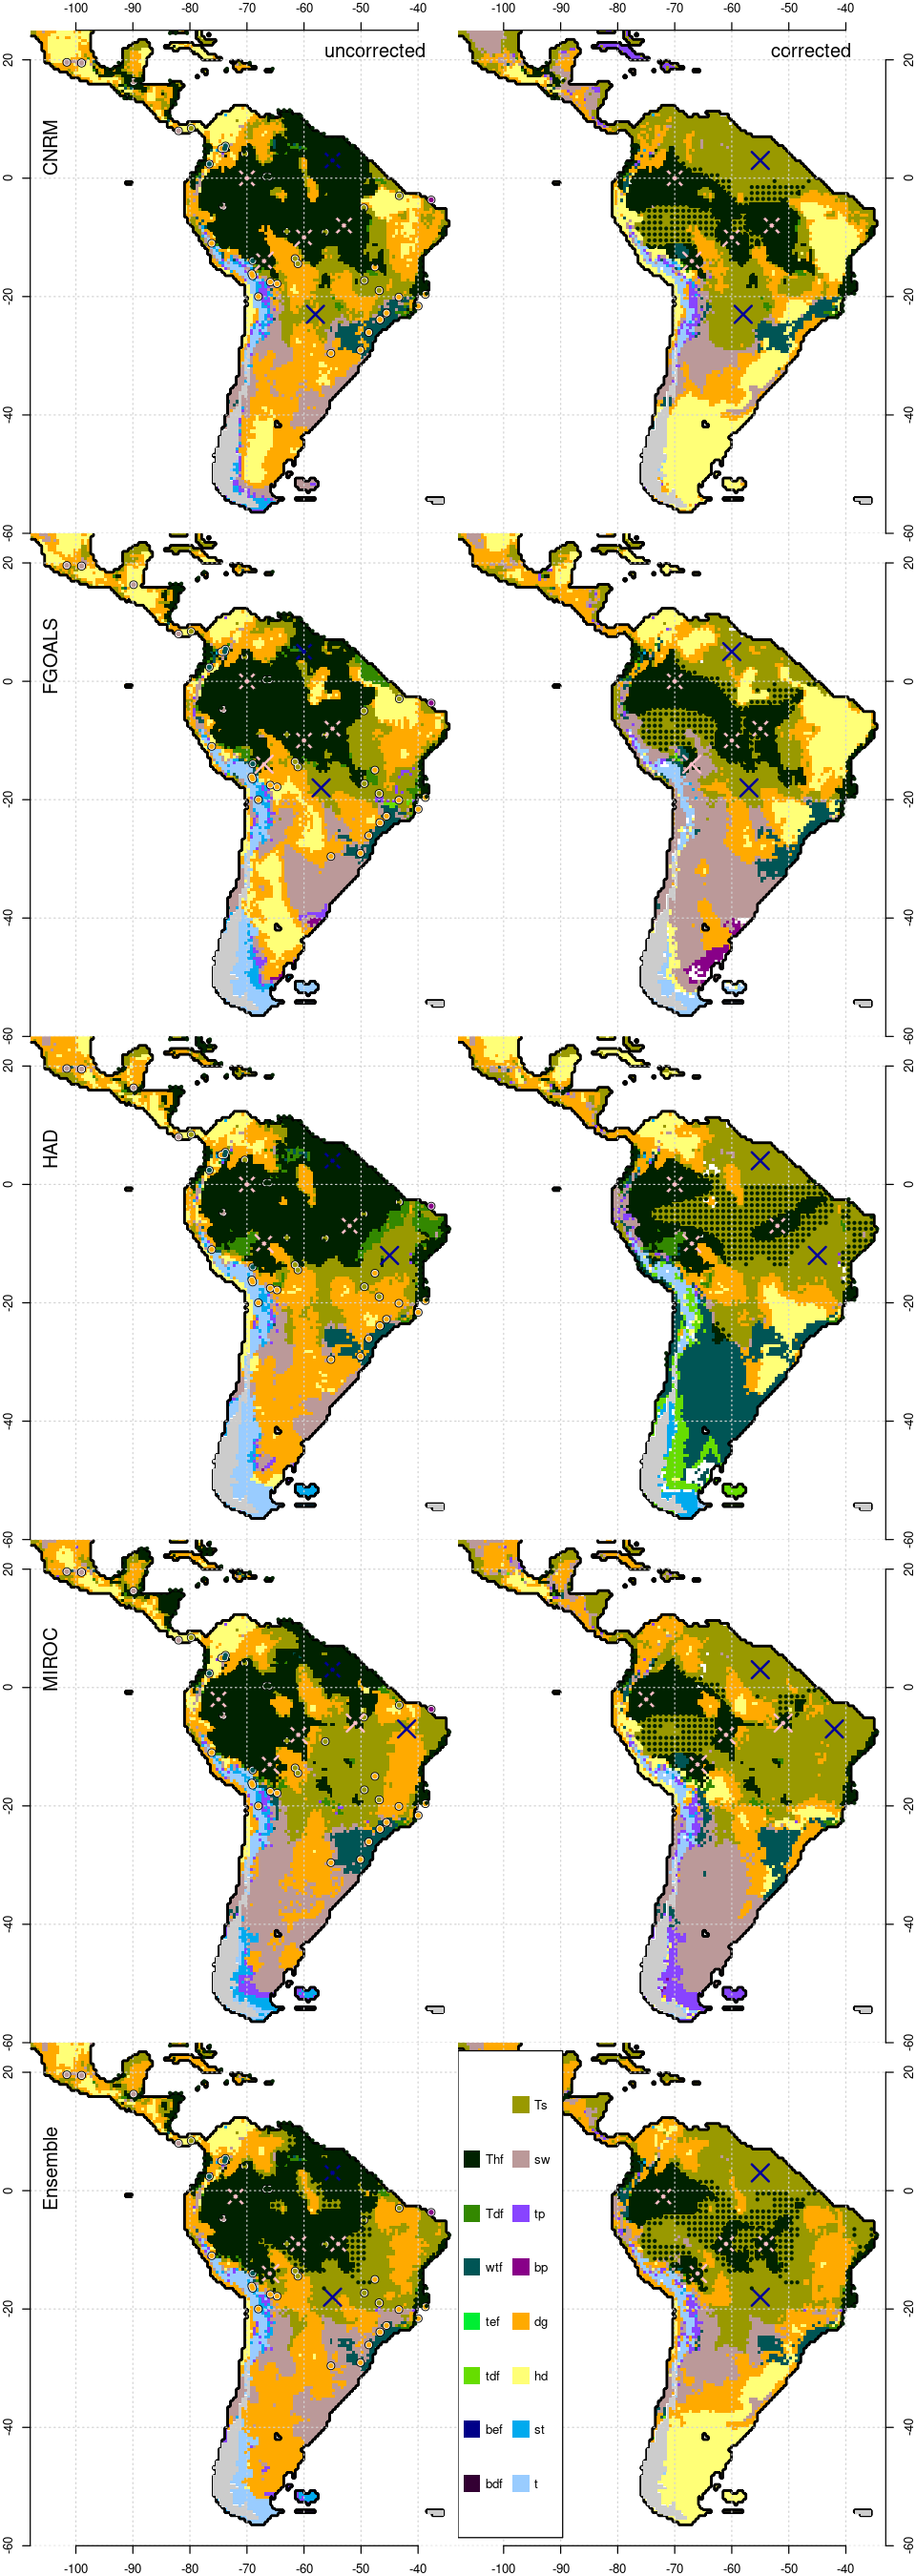

In [116]:
options(repr.plot.width=4*2, repr.plot.height=4.5*5)
par(mfcol = c(5, 2), mar = rep(0, 4), oma = rep(2, 4))

ForestCentres = list(CNRM   = list(c(-70, -0), c(-53, -08), c(-60, -10), c(-67, -14)),
                     FGOALs = list(c(-70, -0), c(-55, -08), c(-60, -10), c(-67, -14)),
                     HADGEM = list(c(-70, -0), c(-52, -07), c(-67, -10)),
                     MIROC  = list(c(-75, -2), c(-51, -06), c(-61, -08), c(-66, -13)),
                     ENS    = list(c(-72, -1), c(-54, -09), c(-61, -09), c(-66, -14)))

SavannaCentres = list(CNRM   = list(c(-55, 3), c(-58, -23)),
                      FGOALS = list(c(-60, 5), c(-57, -18)),
                      HADGEM = list(c(-55, 4), c(-45, -12)),
                      MIROC  = list(c(-55, 3), c(-42, -7)),
                      ENS    = list(c(-55, 3), c(-55, -18)))     

plotBiomes <- function(modid, corid) {
    dat = lapply(zscores[2 + corid,], function(i) i[[modid]])
    biome = biome_assign_precalV(dat[["fpc"]], dat[["evergreen"]], dat[["tropical"]],
                         dat[["temperate"]], dat[["gdd"]], dat[["height"]])    
    
    if (modid == 1) modName = c('uncorrected', 'corrected')[corid] else modName = ''
    if (corid==1) tpoints = TRUE else tpoints = FALSE
    plot_biomes(biome+1, modName, tpoints)
    
    ## forest cent
    addPnts <- function(Centres, col) {
        fc = Centres[[modid]]
        lapply(fc, function(i) points(i[1], i[2], col = col, pch = 4, lwd = 2, cex = 3))
    }
    addPnts(ForestCentres, 'pink')
    addPnts(SavannaCentres, '#000099')
    test = test0 = (biome ==1) | (biome == 8 & dat[["height"]]>5)  
    test = round(raster::aggregate(test, 2))>0

    xyt = xyFromCell(test, which(test[]))
    points(xyt[,1], xyt[,2], cex = 0.5, col = biome_cols[2], pch = 19)
    
    if (corid == 1) mtext(side = 2, modnames[modid], line = -2, ad = 0.8)    
    if (corid==1) axis(2) else axis(4)
    if (modid==1) axis(3)
    if (modid==length(zscores[[1,1]])) axis(1)   
    return(biome)
}
biomes = suppressWarnings(lapply(1:2, function(cid) lapply(1:length(zscores[[1,1]]), plotBiomes, cid)))
legend('left', col = biome_cols, legend = names(biome_cols), pch = 15, ncol = 2, pt.cex = 3)

In [113]:
outputDat <- function(modid, corid) {
    dat = lapply(zscores[2 + corid,], function(i) i[[modid]])
    
    dir = paste0("../outputs/", modnames[modid])
    makeDir(dir)
    dir = paste0(dir, '/', c('uncorrected', 'corrected')[corid])
    makeDir(dir)             
    
    outputVar <- function(varname) {
        file = paste0(dir, '/', varname, ".nc")
        writeRaster(dat[[varname]], file = file, overwrite = TRUE)
    }
    lapply(c("fpc", "evergreen", "tropical", "temperate", "gdd", "height"), outputVar)
        
    
}
lapply(1:2, function(cid) lapply(1:length(zscores[[1,1]]), outputDat, cid))


Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(expr), name, parentenv, handler):
"no CRS normalization available before PROJ 6.3"
Warning message in doTryCatch(return(exp

[[1]]
[[1]][[1]]
[[1]][[1]][[1]]
class      : RasterLayer 
dimensions : 170, 180, 30600  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -120, -30, -60, 25  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : fpc.nc 
names      : layer 
values     : 0.0006629042, 1.000049  (min, max)
zvar       : layer 


[[1]][[1]][[2]]
class      : RasterLayer 
dimensions : 170, 180, 30600  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -120, -30, -60, 25  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : evergreen.nc 
names      : layer 
values     : 0, 1  (min, max)
zvar       : layer 


[[1]][[1]][[3]]
class      : RasterLayer 
dimensions : 170, 180, 30600  (nrow, ncol, ncell)
resolution : 0.5, 0.5  (x, y)
extent     : -120, -30, -60, 25  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
source     : tropical.nc 
names      : layer 
values     : 0, 1  (min, max)
zvar   